In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.transforms import ToTensor
from torch import nn

In [3]:
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import GridSearchCV
import time
# from torch_optimizer import Lookahead

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn

In [6]:
from torchvision.datasets import EMNIST

In [7]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00


In [8]:
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)

In [ ]:
# Loading training dataset
train_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 561753746/561753746 [00:08<00:00, 64176625.16it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [ ]:
# Define the train/val split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [ ]:
# Loading the dataset using data loader and making mini-batches
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=128,
    shuffle=False
)

In [ ]:
# Loading the testing data 
test_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64
)

In [ ]:
# Getting number of rows in training dataset
len(train_dataset)

90240

In [ ]:
# Getting number of rows in validation dataset
len(val_dataset)

22560

In [ ]:
# Getting number of rows in test dataset
len(test_dataset)

18800

In [ ]:
# Creating a mapping dictionary for Emnist labels 

In [ ]:
emnist_labels={
0: 48,
1: 49,
2: 50,
3: 51,
4: 52,
5: 53,
6: 54,
7: 55,
8: 56,
9: 57,
10: 65,
11: 66,
12: 67,
13: 68,
14: 69,
15: 70,
16: 71,
17: 72,
18: 73,
19: 74,
20: 75,
21: 76,
22: 77,
23: 78,
24: 79,
25: 80,
26: 81,
27: 82,
28: 83,
29: 84,
30: 85,
31: 86,
32: 87,
33: 88,
34: 89,
35: 90,
36: 97,
37: 98,
38: 100,
39: 101,
40: 102,
41: 103,
42: 104,
43: 110,
44: 113,
45: 114,
46: 116,
}

In [ ]:
# Getting a list of ascii labels with their characters
ascii_mapping = {}
for i in range(127):
    ascii_mapping[i]=chr(i)
    
# Getting the emnist labels in a df
emnist_df = pd.Series(emnist_labels).to_frame().reset_index()
emnist_df.rename(columns={'index':'ascii',0:'labels'}, inplace=True)

# Getting the ascii labels in a df
ascii_df = pd.Series(ascii_mapping).to_frame().reset_index()
ascii_df.rename(columns={'index':'ascii',0:'chars'}, inplace=True)

# Merging the 2 df to get labels and ascii in one df
emnist_mapping = pd.merge(emnist_df, ascii_df, how="inner", left_on='labels', right_on='ascii')

# emnist_mapping.head(10)

# Removing extra columns
emnist_mapping.drop(['labels','ascii_y'], axis=1, inplace=True)

# emnist_mapping.head()

# Getting the final dictionary to be used at later stage
emnist_dict=dict(zip(emnist_mapping.ascii_x, emnist_mapping.chars))

In [ ]:
# Visualizing the data
image, label=train_dataset[2500]

In [ ]:
print("Shape:", image.shape, "\nLabel:", emnist_dict[label])

Shape: torch.Size([1, 28, 28]) 
Label: O


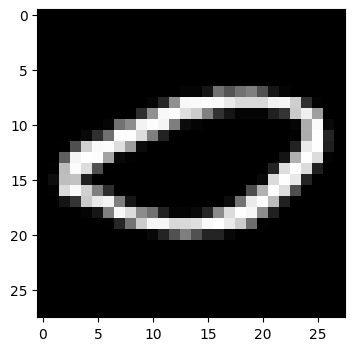

In [ ]:
figure = plt.figure(figsize=(4, 4))
plt.imshow(image.reshape((28,28)), cmap='gray')

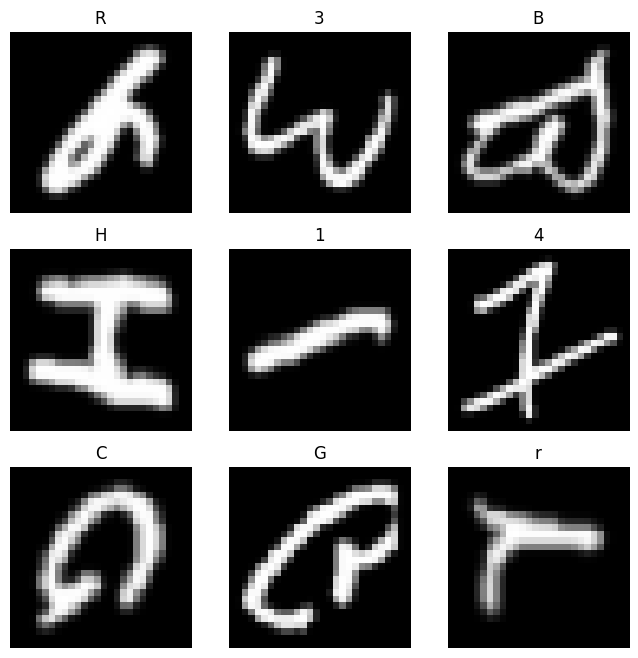

In [ ]:
# Visualizing a few more data points along with their corrected labels
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(emnist_dict[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# MLP

## Looking at the base model

In [ ]:
input_layer=784
hidden_layer=256
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            # nn.Linear(hidden_layer, hidden_layer, bias=True),
            # # nn.BatchNorm1d(hidden_layer),
            # nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer)


# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=20

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()

    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 3.848
time taken for epoch 1 is 39.96
Starting epoch 2
Loss after mini-batch   500: 3.844
time taken for epoch 2 is 33.34
Starting epoch 3
Loss after mini-batch   500: 3.838
time taken for epoch 3 is 32.49
Starting epoch 4
Loss after mini-batch   500: 3.829
time taken for epoch 4 is 33.84
Starting epoch 5
Loss after mini-batch   500: 3.815
train accuracy after epoch 5 is 4.69%
time taken for epoch 5 is 33.16
Starting epoch 6
Loss after mini-batch   500: 3.754
time taken for epoch 6 is 32.36
Starting epoch 7
Loss after mini-batch   500: 3.239
time taken for epoch 7 is 33.89
Starting epoch 8
Loss after mini-batch   500: 2.277
time taken for epoch 8 is 45.63
Starting epoch 9
Loss after mini-batch   500: 1.824
time taken for epoch 9 is 32.59
Starting epoch 10
Loss after mini-batch   500: 1.586
train accuracy after epoch 10 is 56.25%
time taken for epoch 10 is 33.05
Starting epoch 11
Loss after mini-batch   500: 1.448
time taken for epoch 11 is 

In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 23663
train accuracy 73.78%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 5978
Validation accuracy 73.50%


## Batch Normalization


### Without batch normalization

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 1.323
time taken for epoch 1 is 55.39
Starting epoch 2
Loss after mini-batch   500: 0.657
time taken for epoch 2 is 56.19
Starting epoch 3
Loss after mini-batch   500: 0.460
time taken for epoch 3 is 144.36
Starting epoch 4
Loss after mini-batch   500: 0.427
time taken for epoch 4 is 244.56
Starting epoch 5
Loss after mini-batch   500: 0.390
train accuracy after epoch 5 is 86.72%
time taken for epoch 5 is 285.15
Starting epoch 6
Loss after mini-batch   500: 0.384
time taken for epoch 6 is 291.49
Starting epoch 7
Loss after mini-batch   500: 0.378
time taken for epoch 7 is 293.70
Starting epoch 8
Loss after mini-batch   500: 0.376
time taken for epoch 8 is 294.68
Starting epoch 9
Loss after mini-batch   500: 0.379
time taken for epoch 9 is 295.74
Starting epoch 10
Loss after mini-batch   500: 0.376
train accuracy after epoch 10 is 90.62%
time taken for epoch 10 is 295.85
Training process has finished. Time taken is 2257.1218416690826


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 11534
train accuracy 87.22%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3496
Validation accuracy 84.50%


### With batch normalization

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.873
time taken for epoch 1 is 91.39
Starting epoch 2
Loss after mini-batch   500: 0.545
time taken for epoch 2 is 62.26
Starting epoch 3
Loss after mini-batch   500: 0.378
time taken for epoch 3 is 60.69
Starting epoch 4
Loss after mini-batch   500: 0.326
time taken for epoch 4 is 60.16
Starting epoch 5
Loss after mini-batch   500: 0.279
train accuracy after epoch 5 is 89.06%
time taken for epoch 5 is 60.66
Starting epoch 6
Loss after mini-batch   500: 0.265
time taken for epoch 6 is 74.46
Starting epoch 7
Loss after mini-batch   500: 0.255
time taken for epoch 7 is 71.52
Starting epoch 8
Loss after mini-batch   500: 0.250
time taken for epoch 8 is 87.56
Starting epoch 9
Loss after mini-batch   500: 0.250
time taken for epoch 9 is 98.49
Starting epoch 10
Loss after mini-batch   500: 0.250
train accuracy after epoch 10 is 95.31%
time taken for epoch 10 is 94.55
Training process has finished. Time taken is 761.748459815979


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7461
train accuracy 91.73%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2838
Validation accuracy 87.42%


## Improving Hidden Layers

### 3 layers

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            # nn.Linear(hidden_layer, hidden_layer, bias=True),
            # nn.BatchNorm1d(hidden_layer),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.864
time taken for epoch 1 is 49.66
Starting epoch 2
Loss after mini-batch   500: 0.534
time taken for epoch 2 is 49.46
Starting epoch 3
Loss after mini-batch   500: 0.368
time taken for epoch 3 is 54.43
Starting epoch 4
Loss after mini-batch   500: 0.326
time taken for epoch 4 is 54.75
Starting epoch 5
Loss after mini-batch   500: 0.281
train accuracy after epoch 5 is 91.41%
time taken for epoch 5 is 55.14
Training process has finished. Time taken is 263.44245433807373


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7873
train accuracy 91.28%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2872
Validation accuracy 87.27%


### 4 Layers

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
# l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.869
time taken for epoch 1 is 50.07
Starting epoch 2
Loss after mini-batch   500: 0.544
time taken for epoch 2 is 51.74
Starting epoch 3
Loss after mini-batch   500: 0.376
time taken for epoch 3 is 53.58
Starting epoch 4
Loss after mini-batch   500: 0.322
time taken for epoch 4 is 54.76
Starting epoch 5
Loss after mini-batch   500: 0.275
train accuracy after epoch 5 is 90.62%
time taken for epoch 5 is 53.71
Training process has finished. Time taken is 263.8798243999481


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7833
train accuracy 91.32%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2817
Validation accuracy 87.51%


### 5 Layers

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.899
time taken for epoch 1 is 61.21
Starting epoch 2
Loss after mini-batch   500: 0.570
time taken for epoch 2 is 63.74
Starting epoch 3
Loss after mini-batch   500: 0.385
time taken for epoch 3 is 65.83
Starting epoch 4
Loss after mini-batch   500: 0.331
time taken for epoch 4 is 65.44
Starting epoch 5
Loss after mini-batch   500: 0.285
train accuracy after epoch 5 is 92.97%
time taken for epoch 5 is 64.85
Training process has finished. Time taken is 321.0781865119934


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 8040
train accuracy 91.09%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2865
Validation accuracy 87.30%


## Number of Neurons

### Same neurons thoughout - 512

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)


      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.864
time taken for epoch 1 is 48.75
Starting epoch 2
Loss after mini-batch   500: 0.547
time taken for epoch 2 is 49.96
Starting epoch 3
Loss after mini-batch   500: 0.377
time taken for epoch 3 is 54.48
Starting epoch 4
Loss after mini-batch   500: 0.324
time taken for epoch 4 is 52.95
Starting epoch 5
Loss after mini-batch   500: 0.277
train accuracy after epoch 5 is 85.94%
time taken for epoch 5 is 53.05
Starting epoch 6
Loss after mini-batch   500: 0.265
time taken for epoch 6 is 52.49
Starting epoch 7
Loss after mini-batch   500: 0.254
time taken for epoch 7 is 52.42
Starting epoch 8
Loss after mini-batch   500: 0.252
time taken for epoch 8 is 52.22
Starting epoch 9
Loss after mini-batch   500: 0.249
time taken for epoch 9 is 53.63
Starting epoch 10
Loss after mini-batch   500: 0.250
train accuracy after epoch 10 is 91.41%
time taken for epoch 10 is 53.24
Training process has finished. Time taken is 523.1891758441925


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7391
train accuracy 91.81%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2819
Validation accuracy 87.50%


### Same neurons throughout - 256

In [ ]:
input_layer=784
hidden_layer=256
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.967
time taken for epoch 1 is 42.91
Starting epoch 2
Loss after mini-batch   500: 0.541
time taken for epoch 2 is 42.85
Starting epoch 3
Loss after mini-batch   500: 0.387
time taken for epoch 3 is 71.19
Starting epoch 4
Loss after mini-batch   500: 0.338
time taken for epoch 4 is 42.24
Starting epoch 5
Loss after mini-batch   500: 0.305
train accuracy after epoch 5 is 89.06%
time taken for epoch 5 is 43.70
Starting epoch 6
Loss after mini-batch   500: 0.297
time taken for epoch 6 is 42.86
Starting epoch 7
Loss after mini-batch   500: 0.289
time taken for epoch 7 is 43.97
Starting epoch 8
Loss after mini-batch   500: 0.288
time taken for epoch 8 is 43.78
Starting epoch 9
Loss after mini-batch   500: 0.285
time taken for epoch 9 is 42.24
Starting epoch 10
Loss after mini-batch   500: 0.287
train accuracy after epoch 10 is 89.84%
time taken for epoch 10 is 43.54
Training process has finished. Time taken is 459.27866435050964


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 8361
train accuracy 90.73%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2962
Validation accuracy 86.87%


### Varying Neurons per layer [512, 384, 256, 128]

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_layer),
            nn.Linear(784, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(512, 384, bias=True),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            # nn.Linear(hidden_layer, hidden_layer),
            # nn.BatchNorm1d(hidden_layer),
            # nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(384, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(256, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
# Run the training loop
for epoch in range(0, 50): # Testing the epochs between 50 and 100
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      l1_reg = torch.tensor(0.)
      for name, param in mlp.named_parameters():
          if 'weight' in name:
              l1_reg += torch.norm(param, p=1)
      loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0
    
    
    scheduler.step()


    if (epoch+1)%5==0:
        train_correct = 0
        train_wrong = 0
        train_total = 0
        for input_batch, target_batch in train_loader:
            predict_batch = mlp(input_batch) 
        for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
            train_total+=1
            if each.index(max(each)) == result:
                train_correct += 1
            else:
                train_wrong += 1

        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  


# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 5.107
Starting epoch 2
Loss after mini-batch   500: 2.481
Starting epoch 3
Loss after mini-batch   500: 1.859
Starting epoch 4
Loss after mini-batch   500: 1.761
Starting epoch 5
Loss after mini-batch   500: 1.696
train accuracy after epoch 5 is 82.03%
Starting epoch 6
Loss after mini-batch   500: 1.656
Starting epoch 7
Loss after mini-batch   500: 1.627
Starting epoch 8
Loss after mini-batch   500: 1.597
Starting epoch 9
Loss after mini-batch   500: 1.571
Starting epoch 10
Loss after mini-batch   500: 1.546
train accuracy after epoch 10 is 81.25%
Starting epoch 11
Loss after mini-batch   500: 1.281
Starting epoch 12
Loss after mini-batch   500: 1.210
Starting epoch 13
Loss after mini-batch   500: 1.183
Starting epoch 14
Loss after mini-batch   500: 1.170
Starting epoch 15
Loss after mini-batch   500: 1.154
train accuracy after epoch 15 is 84.38%
Starting epoch 16
Loss after mini-batch   500: 1.141
Starting epoch 17
Loss after mini-batch   

In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 10619
train accuracy 88.23%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3327
Validation accuracy 85.25%


## Activation Functions

### Activation functions: Leaky Relu

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.LeakyReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.868
time taken for epoch 1 is 88.42
Starting epoch 2
Loss after mini-batch   500: 0.547
time taken for epoch 2 is 70.24
Starting epoch 3
Loss after mini-batch   500: 0.377
time taken for epoch 3 is 81.30
Starting epoch 4
Loss after mini-batch   500: 0.327
time taken for epoch 4 is 60.09
Starting epoch 5
Loss after mini-batch   500: 0.281
train accuracy after epoch 5 is 89.84%
time taken for epoch 5 is 61.30
Starting epoch 6
Loss after mini-batch   500: 0.265
time taken for epoch 6 is 85.22
Starting epoch 7
Loss after mini-batch   500: 0.257
time taken for epoch 7 is 86.94
Starting epoch 8
Loss after mini-batch   500: 0.252
time taken for epoch 8 is 93.96
Starting epoch 9
Loss after mini-batch   500: 0.250
time taken for epoch 9 is 92.30
Starting epoch 10
Loss after mini-batch   500: 0.250
train accuracy after epoch 10 is 92.19%
time taken for epoch 10 is 62.10
Training process has finished. Time taken is 781.8736691474915


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7412
train accuracy 91.79%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2785
Validation accuracy 87.66%


### ELU

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ELU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ELU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ELU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ELU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 1.062
time taken for epoch 1 is 50.82
Starting epoch 2
Loss after mini-batch   500: 0.766
time taken for epoch 2 is 52.08
Starting epoch 3
Loss after mini-batch   500: 0.553
time taken for epoch 3 is 54.50
Starting epoch 4
Loss after mini-batch   500: 0.508
time taken for epoch 4 is 54.91
Starting epoch 5
Loss after mini-batch   500: 0.449
train accuracy after epoch 5 is 83.59%
time taken for epoch 5 is 53.24
Training process has finished. Time taken is 265.5473117828369


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 12368
train accuracy 86.29%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3460
Validation accuracy 84.66%


### TanH

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.Tanh(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.Tanh(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.Tanh(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.Tanh(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 1.165
time taken for epoch 1 is 49.90
Starting epoch 2
Loss after mini-batch   500: 0.840
time taken for epoch 2 is 50.57
Starting epoch 3
Loss after mini-batch   500: 0.588
time taken for epoch 3 is 54.70
Starting epoch 4
Loss after mini-batch   500: 0.527
time taken for epoch 4 is 53.45
Starting epoch 5
Loss after mini-batch   500: 0.465
train accuracy after epoch 5 is 83.59%
time taken for epoch 5 is 53.86
Training process has finished. Time taken is 262.4890639781952


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 12780
train accuracy 85.84%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3593
Validation accuracy 84.07%


### ReLU

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.873
time taken for epoch 1 is 57.59
Starting epoch 2
Loss after mini-batch   500: 0.549
time taken for epoch 2 is 66.57
Starting epoch 3
Loss after mini-batch   500: 0.376
time taken for epoch 3 is 54.05
Starting epoch 4
Loss after mini-batch   500: 0.326
time taken for epoch 4 is 64.95
Starting epoch 5
Loss after mini-batch   500: 0.280
train accuracy after epoch 5 is 89.84%
time taken for epoch 5 is 56.29
Starting epoch 6
Loss after mini-batch   500: 0.266
time taken for epoch 6 is 55.47
Starting epoch 7
Loss after mini-batch   500: 0.255
time taken for epoch 7 is 54.37
Starting epoch 8
Loss after mini-batch   500: 0.249
time taken for epoch 8 is 54.25
Starting epoch 9
Loss after mini-batch   500: 0.250
time taken for epoch 9 is 53.66
Starting epoch 10
Loss after mini-batch   500: 0.248
train accuracy after epoch 10 is 91.41%
time taken for epoch 10 is 53.77
Training process has finished. Time taken is 570.9919564723969


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7461
train accuracy 91.73%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2814
Validation accuracy 87.53%


## Optimizers

### ASGD

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.ASGD(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 3.476
time taken for epoch 1 is 50.47
Starting epoch 2
Loss after mini-batch   500: 2.528
time taken for epoch 2 is 46.84
Starting epoch 3
Loss after mini-batch   500: 2.114
time taken for epoch 3 is 46.87
Starting epoch 4
Loss after mini-batch   500: 2.042
time taken for epoch 4 is 46.55
Starting epoch 5
Loss after mini-batch   500: 1.995
train accuracy after epoch 5 is 60.94%
time taken for epoch 5 is 47.79
Starting epoch 6
Loss after mini-batch   500: 1.984
time taken for epoch 6 is 45.73
Starting epoch 7
Loss after mini-batch   500: 1.980
time taken for epoch 7 is 46.96
Starting epoch 8
Loss after mini-batch   500: 1.981
time taken for epoch 8 is 46.86
Starting epoch 9
Loss after mini-batch   500: 1.977
time taken for epoch 9 is 47.62
Starting epoch 10
Loss after mini-batch   500: 1.974
train accuracy after epoch 10 is 64.06%
time taken for epoch 10 is 45.48
Training process has finished. Time taken is 471.1806116104126


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 36623
train accuracy 59.42%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 9318
Validation accuracy 58.70%


### Adam

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.869
time taken for epoch 1 is 56.21
Starting epoch 2
Loss after mini-batch   500: 0.546
time taken for epoch 2 is 50.99
Starting epoch 3
Loss after mini-batch   500: 0.375
time taken for epoch 3 is 56.12
Starting epoch 4
Loss after mini-batch   500: 0.327
time taken for epoch 4 is 56.56
Starting epoch 5
Loss after mini-batch   500: 0.280
train accuracy after epoch 5 is 89.06%
time taken for epoch 5 is 57.19
Starting epoch 6
Loss after mini-batch   500: 0.265
time taken for epoch 6 is 56.07
Starting epoch 7
Loss after mini-batch   500: 0.254
time taken for epoch 7 is 56.58
Starting epoch 8
Loss after mini-batch   500: 0.250
time taken for epoch 8 is 55.41
Starting epoch 9
Loss after mini-batch   500: 0.250
time taken for epoch 9 is 55.95
Starting epoch 10
Loss after mini-batch   500: 0.248
train accuracy after epoch 10 is 92.19%
time taken for epoch 10 is 55.41
Training process has finished. Time taken is 556.5036206245422


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7387
train accuracy 91.81%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2808
Validation accuracy 87.55%


### SGD

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 3.481
time taken for epoch 1 is 51.05
Starting epoch 2
Loss after mini-batch   500: 2.529
time taken for epoch 2 is 51.33
Starting epoch 3
Loss after mini-batch   500: 2.105
time taken for epoch 3 is 51.26
Starting epoch 4
Loss after mini-batch   500: 2.040
time taken for epoch 4 is 51.65
Starting epoch 5
Loss after mini-batch   500: 1.994
train accuracy after epoch 5 is 67.19%
time taken for epoch 5 is 51.43
Starting epoch 6
Loss after mini-batch   500: 1.985
time taken for epoch 6 is 50.78
Starting epoch 7
Loss after mini-batch   500: 1.973
time taken for epoch 7 is 52.27
Starting epoch 8
Loss after mini-batch   500: 1.976
time taken for epoch 8 is 56.50
Starting epoch 9
Loss after mini-batch   500: 1.973
time taken for epoch 9 is 51.08
Starting epoch 10
Loss after mini-batch   500: 1.974
train accuracy after epoch 10 is 64.06%
time taken for epoch 10 is 50.84
Training process has finished. Time taken is 518.1836392879486


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 36644
train accuracy 59.39%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 9346
Validation accuracy 58.57%


### Adamax

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.919
time taken for epoch 1 is 60.62
Starting epoch 2
Loss after mini-batch   500: 0.490
time taken for epoch 2 is 58.41
Starting epoch 3
Loss after mini-batch   500: 0.345
time taken for epoch 3 is 61.96
Starting epoch 4
Loss after mini-batch   500: 0.306
time taken for epoch 4 is 60.82
Starting epoch 5
Loss after mini-batch   500: 0.273
train accuracy after epoch 5 is 91.41%
time taken for epoch 5 is 61.08
Starting epoch 6
Loss after mini-batch   500: 0.271
time taken for epoch 6 is 60.65
Starting epoch 7
Loss after mini-batch   500: 0.264
time taken for epoch 7 is 60.19
Starting epoch 8
Loss after mini-batch   500: 0.261
time taken for epoch 8 is 61.72
Starting epoch 9
Loss after mini-batch   500: 0.262
time taken for epoch 9 is 60.94
Starting epoch 10
Loss after mini-batch   500: 0.262
train accuracy after epoch 10 is 92.97%
time taken for epoch 10 is 60.62
Training process has finished. Time taken is 607.0134239196777


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7534
train accuracy 91.65%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3041
Validation accuracy 86.52%


## Learning Rate Schedulers

### Exponential LR

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.868
time taken for epoch 1 is 49.45
Starting epoch 2
Loss after mini-batch   500: 0.422
time taken for epoch 2 is 52.03
Starting epoch 3
Loss after mini-batch   500: 0.346
time taken for epoch 3 is 54.44
Starting epoch 4
Loss after mini-batch   500: 0.329
time taken for epoch 4 is 53.34
Starting epoch 5
Loss after mini-batch   500: 0.324
train accuracy after epoch 5 is 88.28%
time taken for epoch 5 is 52.94
Training process has finished. Time taken is 262.20744276046753


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 9492
train accuracy 89.48%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3021
Validation accuracy 86.61%


### Step LR

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.871
time taken for epoch 1 is 48.68
Starting epoch 2
Loss after mini-batch   500: 0.554
time taken for epoch 2 is 49.52
Starting epoch 3
Loss after mini-batch   500: 0.379
time taken for epoch 3 is 52.85
Starting epoch 4
Loss after mini-batch   500: 0.327
time taken for epoch 4 is 52.37
Starting epoch 5
Loss after mini-batch   500: 0.280
train accuracy after epoch 5 is 90.62%
time taken for epoch 5 is 52.48
Training process has finished. Time taken is 255.9044840335846


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7916
train accuracy 91.23%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2822
Validation accuracy 87.49%


### Multi-Step LR

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=5

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.871
time taken for epoch 1 is 48.92
Starting epoch 2
Loss after mini-batch   500: 0.547
time taken for epoch 2 is 50.02
Starting epoch 3
Loss after mini-batch   500: 0.376
time taken for epoch 3 is 53.27
Starting epoch 4
Loss after mini-batch   500: 0.320
time taken for epoch 4 is 52.43
Starting epoch 5
Loss after mini-batch   500: 0.277
train accuracy after epoch 5 is 92.19%
time taken for epoch 5 is 52.91
Training process has finished. Time taken is 257.54678201675415


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7779
train accuracy 91.38%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2832
Validation accuracy 87.45%


## Regularization

### With L1

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
# , weight_decay=0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.25)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      l1_reg = torch.tensor(0.)
      for name, param in mlp.named_parameters():
          if 'weight' in name:
              l1_reg += torch.norm(param, p=1)
      loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 9.880
time taken for epoch 1 is 60.21
Starting epoch 2
Loss after mini-batch   500: 3.988
time taken for epoch 2 is 60.10
Starting epoch 3
Loss after mini-batch   500: 2.825
time taken for epoch 3 is 58.16
Starting epoch 4
Loss after mini-batch   500: 2.524
time taken for epoch 4 is 59.47
Starting epoch 5
Loss after mini-batch   500: 2.333
train accuracy after epoch 5 is 88.28%
time taken for epoch 5 is 59.27
Starting epoch 6
Loss after mini-batch   500: 2.278
time taken for epoch 6 is 59.04
Starting epoch 7
Loss after mini-batch   500: 2.243
time taken for epoch 7 is 59.25
Starting epoch 8
Loss after mini-batch   500: 2.232
time taken for epoch 8 is 59.57
Starting epoch 9
Loss after mini-batch   500: 2.228
time taken for epoch 9 is 58.64
Starting epoch 10
Loss after mini-batch   500: 2.224
train accuracy after epoch 10 is 89.84%
time taken for epoch 10 is 59.62
Training process has finished. Time taken is 593.3344416618347


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 10451
train accuracy 88.42%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3081
Validation accuracy 86.34%


### Without L1 & L2 Regularization

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # nn.BatchNorm1d(input_layer),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.852
time taken for epoch 1 is 49.93
Starting epoch 2
Loss after mini-batch   500: 0.493
time taken for epoch 2 is 49.38
Starting epoch 3
Loss after mini-batch   500: 0.333
time taken for epoch 3 is 48.81
Starting epoch 4
Loss after mini-batch   500: 0.290
time taken for epoch 4 is 48.68
Starting epoch 5
Loss after mini-batch   500: 0.256
train accuracy after epoch 5 is 92.19%
time taken for epoch 5 is 48.78
Starting epoch 6
Loss after mini-batch   500: 0.248
time taken for epoch 6 is 49.51
Starting epoch 7
Loss after mini-batch   500: 0.239
time taken for epoch 7 is 49.23
Starting epoch 8
Loss after mini-batch   500: 0.238
time taken for epoch 8 is 49.00
Starting epoch 9
Loss after mini-batch   500: 0.237
time taken for epoch 9 is 49.53
Starting epoch 10
Loss after mini-batch   500: 0.236
train accuracy after epoch 10 is 93.75%
time taken for epoch 10 is 48.48
Training process has finished. Time taken is 491.33738899230957


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7404
train accuracy 91.80%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2887
Validation accuracy 87.20%


### Dropout

### Dropout = 0.3

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 1.263
time taken for epoch 1 is 52.01
Starting epoch 2
Loss after mini-batch   500: 0.777
time taken for epoch 2 is 52.94
Starting epoch 3
Loss after mini-batch   500: 0.606
time taken for epoch 3 is 56.20
Starting epoch 4
Loss after mini-batch   500: 0.552
time taken for epoch 4 is 56.47
Starting epoch 5
Loss after mini-batch   500: 0.518
train accuracy after epoch 5 is 83.59%
time taken for epoch 5 is 54.22
Starting epoch 6
Loss after mini-batch   500: 0.513
time taken for epoch 6 is 54.70
Starting epoch 7
Loss after mini-batch   500: 0.499
time taken for epoch 7 is 54.51
Starting epoch 8
Loss after mini-batch   500: 0.502
time taken for epoch 8 is 55.02
Starting epoch 9
Loss after mini-batch   500: 0.502
time taken for epoch 9 is 56.46
Starting epoch 10
Loss after mini-batch   500: 0.499
train accuracy after epoch 10 is 82.81%
time taken for epoch 10 is 54.51
Training process has finished. Time taken is 547.0613083839417


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 11394
train accuracy 87.37%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 3264
Validation accuracy 85.53%


### Dropout = 0.5

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 1.758
time taken for epoch 1 is 56.33
Starting epoch 2
Loss after mini-batch   500: 1.068
time taken for epoch 2 is 58.45
Starting epoch 3
Loss after mini-batch   500: 0.879
time taken for epoch 3 is 61.91
Starting epoch 4
Loss after mini-batch   500: 0.814
time taken for epoch 4 is 62.46
Starting epoch 5
Loss after mini-batch   500: 0.778
train accuracy after epoch 5 is 85.16%
time taken for epoch 5 is 61.75
Starting epoch 6
Loss after mini-batch   500: 0.765
time taken for epoch 6 is 61.72
Starting epoch 7
Loss after mini-batch   500: 0.758
time taken for epoch 7 is 60.67
Starting epoch 8
Loss after mini-batch   500: 0.762
time taken for epoch 8 is 61.40
Starting epoch 9
Loss after mini-batch   500: 0.750
time taken for epoch 9 is 61.53
Starting epoch 10
Loss after mini-batch   500: 0.754
train accuracy after epoch 10 is 82.03%
time taken for epoch 10 is 61.96
Training process has finished. Time taken is 608.1918625831604


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 14873
train accuracy 83.52%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 4003
Validation accuracy 82.26%


### No Dropout

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=10

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.876
time taken for epoch 1 is 57.38
Starting epoch 2
Loss after mini-batch   500: 0.547
time taken for epoch 2 is 56.88
Starting epoch 3
Loss after mini-batch   500: 0.374
time taken for epoch 3 is 59.12
Starting epoch 4
Loss after mini-batch   500: 0.323
time taken for epoch 4 is 60.54
Starting epoch 5
Loss after mini-batch   500: 0.279
train accuracy after epoch 5 is 93.75%
time taken for epoch 5 is 60.13
Starting epoch 6
Loss after mini-batch   500: 0.263
time taken for epoch 6 is 59.91
Starting epoch 7
Loss after mini-batch   500: 0.251
time taken for epoch 7 is 59.12
Starting epoch 8
Loss after mini-batch   500: 0.250
time taken for epoch 8 is 60.13
Starting epoch 9
Loss after mini-batch   500: 0.247
time taken for epoch 9 is 60.08
Starting epoch 10
Loss after mini-batch   500: 0.250
train accuracy after epoch 10 is 90.62%
time taken for epoch 10 is 59.81
Training process has finished. Time taken is 593.1174147129059


In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7427
train accuracy 91.77%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2806
Validation accuracy 87.56%


## Best Model

In [ ]:
input_layer=784
hidden_layer=512
output_layer=47

class MLP(nn.Module):
    #Multi-Layer Perceptron

    def __init__(self):
        #Super class initialization
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, hidden_layer, bias=True),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(hidden_layer, output_layer),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [ ]:
mlp=MLP()
# optimizer = torch.optim.Adamax(mlp.parameters(), lr=0.001)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma=0.15)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.15)
criterion = nn.CrossEntropyLoss()
l1_coeff=0.001

In [ ]:
train_losses = []
train_accs=[]

epochs=50

total_start_time=time.time()
# Run the training loop
for epoch in range(epochs): # Testing the epochs between 50 and 100
    
    # Start timing the training process
    start_time = time.time()


    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data

    for i, data in enumerate(train_loader, 0):
      
      # Get inputs
      inputs, targets = data
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = criterion(outputs, targets)

      # L1 regularization
      # l1_reg = torch.tensor(0.)
      # for name, param in mlp.named_parameters():
      #     if 'weight' in name:
      #         l1_reg += torch.norm(param, p=1)
      # loss += l1_coeff * l1_reg

      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    train_losses.append(loss.item())
    
    scheduler.step()


    train_correct = 0
    train_wrong = 0
    train_total = 0
    for input_batch, target_batch in train_loader:
        predict_batch = mlp(input_batch) 
    for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
        train_total+=1
        if each.index(max(each)) == result:
            train_correct += 1
        else:
            train_wrong += 1

    train_accs.append((train_correct/train_total)*100)
    
    if (epoch+1)%5==0:
        print(f'train accuracy after epoch {epoch+1} is {(train_correct/train_total)*100:.2f}%')  

    end_time=time.time()
    
    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')

# Process is complete.
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time}')

Starting epoch 1
Loss after mini-batch   500: 0.872
time taken for epoch 1 is 56.68
Starting epoch 2
Loss after mini-batch   500: 0.543
time taken for epoch 2 is 56.61
Starting epoch 3
Loss after mini-batch   500: 0.375
time taken for epoch 3 is 61.17
Starting epoch 4
Loss after mini-batch   500: 0.323
time taken for epoch 4 is 59.65
Starting epoch 5
Loss after mini-batch   500: 0.281
train accuracy after epoch 5 is 93.75%
time taken for epoch 5 is 61.39
Starting epoch 6
Loss after mini-batch   500: 0.263
time taken for epoch 6 is 60.47
Starting epoch 7
Loss after mini-batch   500: 0.253
time taken for epoch 7 is 60.94
Starting epoch 8
Loss after mini-batch   500: 0.253
time taken for epoch 8 is 60.49
Starting epoch 9
Loss after mini-batch   500: 0.251
time taken for epoch 9 is 59.67
Starting epoch 10
Loss after mini-batch   500: 0.250
train accuracy after epoch 10 is 89.84%
time taken for epoch 10 is 60.19
Starting epoch 11
Loss after mini-batch   500: 0.250
time taken for epoch 11 is

In [ ]:
# sets the model in evaluation mode 
mlp.eval()

# Train dataset
train_correct = 0
train_wrong = 0
train_total = 0
for input_batch, target_batch in train_loader:
  predict_batch = mlp(input_batch)
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    train_total+=1
    if each.index(max(each)) == result:
      train_correct += 1
    else:
      train_wrong += 1

print('Training:')
print('number of train data: ' + str(train_total))
print(f'number of wrongly predicted label {train_wrong}')
print(f'train accuracy {(train_correct/train_total)*100:.2f}%')

print('--------------------------------------------------')

# Vaidation dataset
val_correct = 0
val_wrong = 0
val_total = 0
for input_batch, target_batch in val_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    val_total+=1
    if each.index(max(each)) == result:
      val_correct+=1
    else:
      val_wrong+=1

print('Validation:')
print('number of validation data: ' + str(val_total))
print(f'number of wrongly predicted label {val_wrong}')
print(f'Validation accuracy {(val_correct/val_total)*100:.2f}%')

Training:
number of train data: 90240
number of wrongly predicted label 7506
train accuracy 91.68%
--------------------------------------------------
Validation:
number of validation data: 22560
number of wrongly predicted label 2805
Validation accuracy 87.57%


In [ ]:
# Test dataset
test_correct = 0
test_wrong = 0
test_total = 0
for input_batch, target_batch in test_loader:
  predict_batch = mlp(input_batch) 
  for each,result in zip(predict_batch.tolist(),target_batch.tolist()):
    test_total+=1
    if each.index(max(each)) == result:
      test_correct += 1
    else:
      test_wrong += 1

print('Testing:')
print('number of test data: ' + str(test_total))
print(f'number of wrongly predicted label {test_wrong}')
print(f'test accuracy {(test_correct/test_total)*100:.2f}%')

Testing:
number of test data: 18800
number of wrongly predicted label 2396
test accuracy 87.26%


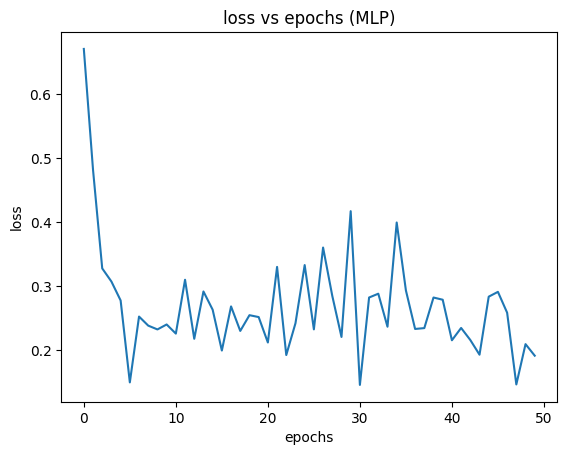

In [ ]:
plt.plot(train_losses)
plt.title("loss vs epochs (MLP)")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

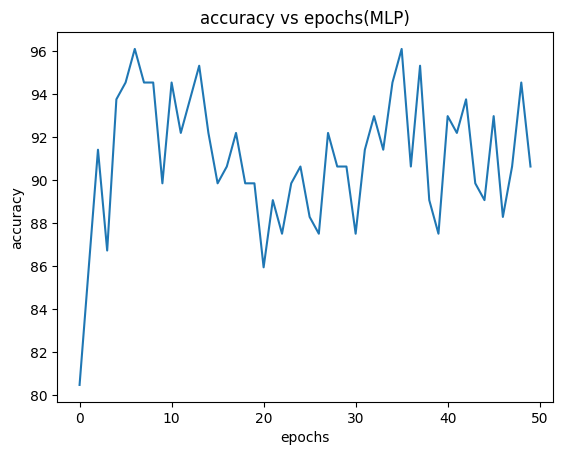

In [ ]:
plt.plot(train_accs)
plt.title("accuracy vs epochs (MLP)")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

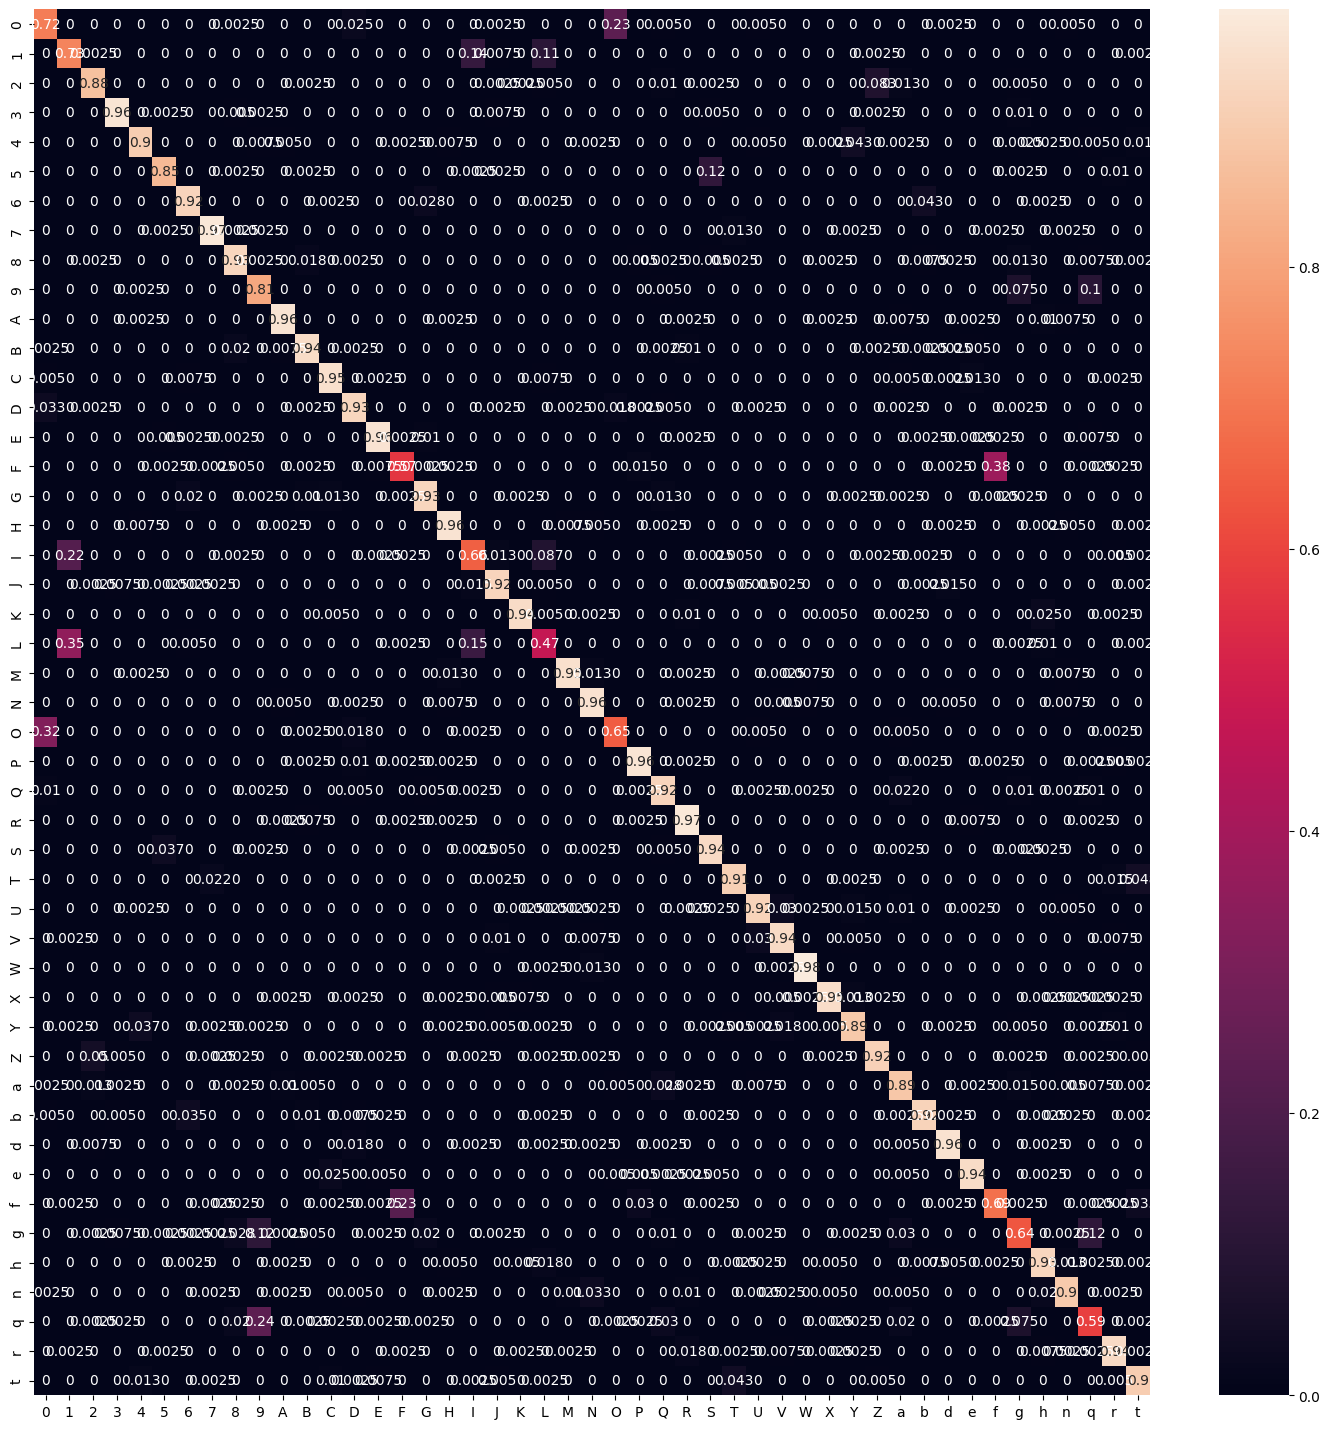

In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_loader:
        output = mlp(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = (emnist_dict.values())


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (18,18))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision for best MLP model is {precision*100:.2f}")
print(f"Recall for best MLP model is {recall*100:.2f}")
print(f"F1 for best MLP model is {f1*100:.2f}")


Precision for best MLP model is 87.26
Recall for best MLP model is 87.26
F1 for best MLP model is 87.26


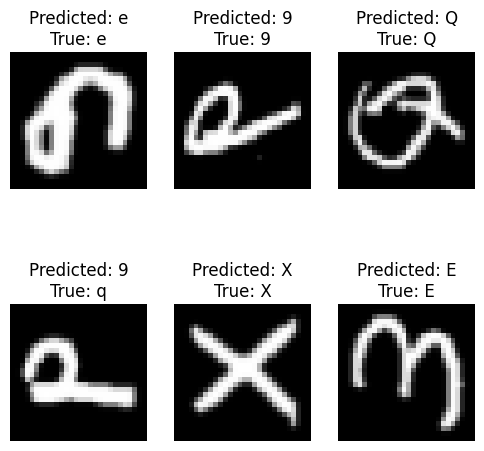

In [ ]:
figure=plt.figure(figsize=(6,6))
for i in range(1, 7):
    
    input, true_label = test_dataset[i] 
    predict_batch = mlp(input)
    a=predict_batch[0].tolist()
    pred_label= a.index(max(a))

    figure.add_subplot(2, 3, i)
    plt.title(f'Predicted: {emnist_dict[pred_label]}\nTrue: {emnist_dict[true_label]}')
    # plt.title(emnist_dict[pred_label])
    # plt.xlabel(emnist_dict[true_label])
    plt.axis("off")
    plt.imshow(input.squeeze(), cmap="gray")
plt.show()

## Convolutional Neural Network (CNN)

### Base Model for CNN: This is where we keep all the parameters as default and from here on we will tune the parameters

In [16]:
class CNN(nn.Module):
    def __init__(self, activation, dropout, batchnorm, l1, l2):
        super().__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Define the first batch normalization layer
        self.bn1 = nn.BatchNorm2d(32) if batchnorm else nn.Identity()
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Define the second batch normalization layer
        self.bn2 = nn.BatchNorm2d(64) if batchnorm else nn.Identity()
        # Define the flatten layer
        self.flatten = nn.Flatten()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        # Define the third batch normalization layer
        self.bn3 = nn.BatchNorm1d(512) if batchnorm else nn.Identity()
        # Define the second fully connected layer
        self.fc2 = nn.Linear(512, 47)
        # Define the dropout layer
        self.dropout = nn.Dropout(dropout)
        # Define the activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        # Define the L1 regularization parameter
        self.l1 = l1
        # Define the L2 regularization parameter
        self.l2 = l2

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x))) # Convolutional layer 1
        x = F.max_pool2d(x, 2) # Max pooling layer 1
        x = self.activation(self.bn2(self.conv2(x))) # Convolutional layer 2
        x = F.max_pool2d(x, 2) # Max pooling layer 2
        x = self.flatten(x) # Flatten the output of the convolutional layers
        x = self.activation(self.bn3(self.fc1(x))) # Fully connected layer 1
        x = self.dropout(x) # Dropout layer
        x = self.fc2(x) # Fully connected layer 2
        return F.log_softmax(x, dim=-1) # Softmax activation function


# To Load the EMNIST dataset
transform = transforms.Compose([transforms.Resize((28, 28)), # Resize the image to 28x28 pixels
                                transforms.ToTensor(), # Convert the image to a tensor
                                transforms.Normalize((0.5,), (0.5,))]) # Normalize the pixel values

train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform) # Load the training dataset
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform) # Load the testing dataset

# Split the training dataset into train and validation sets
train_indices = list(range(len(train_dataset)))
split = int(len(train_dataset) * 0.2)
train_sampler = SubsetRandomSampler(train_indices[split:])
valid_sampler = SubsetRandomSampler(train_indices[:split])

# data loaders
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=128, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Define the base CNN model before hyperparameter tuning
model = CNN(activation='elu', dropout=0.5, batchnorm=False, l1=0.0, l2=0.0) 
criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optim.SGD(model.parameters(), lr=0.01) # Define the optimizer

# Setting the number of epochs and initializing lists to store losses and accuracies for the base model
num_epochs = 10 # Number of epochs to train the base model
train_losses, valid_losses = [], [] # Lists to store training and testing losses
train_accs, valid_accs = [], [] # Lists to store training and testing accuracies
least_train_loss, best_train_acc = float('inf'), 0 # Variables to store the least training loss and best training accuracy

# Start time of the training process of the base model
start_time = time.time()

# Loop through each epoch
for epoch in range(num_epochs): # Loop through each epoch
    running_loss = 0.0 # Initialize running loss
    running_valid_loss = 0.0 # Initialize running validation loss
    correct_train, total_train = 0, 0 # Initialize counters for training accuracy
    correct_valid, total_valid = 0, 0 # Initialize counters for validation accuracy

    # Loop through each batch in the training data loader
    for batch_idx, (data, targets) in enumerate(train_loader):
        
        # Zero out gradients, get predictions, calculate loss, backpropagate, and update weights
        optimizer.zero_grad() # Zero out gradients 
        scores = model(data) # Get predictions
        loss = criterion(scores, targets) # Calculate loss
        loss.backward() # Backpropagate
        optimizer.step() # Update weights

        # Calculate training accuracy and update counters
        _, predicted_train = torch.max(scores.data, 1) # Get predicted classes
        total_train += targets.size(0) # Update total number of training samples
        correct_train += (predicted_train == targets).sum().item() # Update number of correctly classified training samples
        train_acc = 100.0 * correct_train / total_train # Calculate training accuracy

        # Calculate training loss and update running loss
        running_loss += loss.item() # Add current batch loss to running loss

    # Evaluate the model on the validation set
    with torch.no_grad(): # Turn off gradient computation to save memory and computation time
        for data, targets in valid_loader:
            scores = model(data) # Get predictions
            _, predicted_valid = torch.max(scores.data, 1) # Get predicted classes
            total_valid += targets.size(0) # Update total number of validation samples
            correct_valid += (predicted_valid == targets).sum().item() # Update number of correctly classified validation samples
    valid_acc = 100.0 * correct_valid / total_valid # Calculate validation accuracy
    
    # Calculate average loss and accuracy for this epoch and add to respective lists
    train_losses.append(running_loss / len(train_loader)) # Calculate average training loss for this epoch
    train_accs.append(train_acc) # Add training accuracy for this epoch to list of training accuracies
    valid_accs.append(valid_acc) # Add validation accuracy for this epoch to list of validation accuracies
    
    # Check if this epoch has the best training loss or accuracy so far
    if train_losses[-1] < least_train_loss: # If this epoch has the least training loss so far
        least_train_loss = train_losses[-1] # Update least training loss
    if train_accs[-1] > best_train_acc: # If this epoch has the best training accuracy so far
        best_train_acc = train_accs[-1] # Update best training accuracy
    
    # Print results for this epoch
    end_time = time.time()

# Calculate total training time
total_time_taken = (end_time - start_time)/60

# Print final results
print(f'Total time taken to complete the training: {total_time_taken:.2f}m')
print(f'Least Training Loss: {least_train_loss:.4f}')
print(f'Best Training Accuracy: {best_train_acc:.2f}%')
print(f"Validation Accuracy: {valid_acc:.2f}%")

Total time taken to complete the training: 19.42m
Least Training Loss: 0.4733
Best Training Accuracy: 83.98%
Validation Accuracy: 83.12%


### Tuning the parameters using a similar approach as GridSearch

In [ ]:
# Define the hyperparameters to explore
learning_rates = [0.01, 0.001]
scheduler_types = ["StepLR"]
scheduler_params = [{"step_size": 10, "gamma": 0.1}, {"factor": 0.1, "patience": 5}]
activation = ['relu', 'LeakyReLU', 'elu']
dropout = [0.5]
weight_decays = [0.001]
batch_norm = [True, False]
max_epochs = [10]
module__l1 = [ 0.01]
module__l2 = [ 0.001]
optimizer = [optim.SGD, optim.Adam, optim.Adagrad]
batch_size = [128]

In [ ]:
best_lr_scheduler = None # Best learning rate scheduler
best_lr_scheduler_type = "" # Type of best learning rate scheduler
best_lr_scheduler_params = {} # Parameters of best learning rate scheduler
best_val_acc = 0 # Best validation accuracy

for dropout in dropout: # Loop over dropout rates
    for weight_decay in weight_decays: # Loop over weight decay rates
        for batch_norm in batch_norm: # Loop over batch normalization options
            for learning_rate in learning_rates: # Loop over learning rates
                for activation in activation: # Loop over activation functions
                    for optimizer_fn in optimizer: # Loop over optimizers
                        for scheduler_type, scheduler_param in zip(scheduler_types, scheduler_params): # Loop over scheduler types and parameters
                            # Define the CNN model with the given hyperparameters
                            model = CNN(activation, dropout=dropout, l1=module__l1, l2=module__l2, batchnorm=batch_norm)

                            # Define the loss function
                            criterion = nn.CrossEntropyLoss()

                            # Define the optimizer parameters
                            optimizer_params = {
                                'lr': learning_rate, # learning rate
                                'weight_decay': weight_decay # weight decay
                            }

                            # Define the optimizer instance
                            optimizer_instance = optimizer_fn(model.parameters(), **optimizer_params)

                            # Define the scheduler
                            scheduler = optim.lr_scheduler.StepLR(optimizer_instance, **scheduler_param) # StepLR scheduler

                            # Train the model
                            num_epochs = max_epochs  # set the number of epochs to the maximum number of epochs
                            train_losses = []  # initialize an empty list to store training losses
                            train_accs = []  # initialize an empty list to store training accuracies
                            val_losses = []  # initialize an empty list to store validation losses
                            val_accs = []  # initialize an empty list to store validation accuracies
                            best_val_loss = float('inf')  # set the best validation loss to infinity
                            best_val_acc = 0.0  # set the best validation accuracy to zero
                            num_epochs = int(num_epochs[0])  # convert list to integer

                            # loop through each epoch
                            for epoch in range(num_epochs):
                                # Train the model
                                model.train()  # set the model to train mode
                                train_loss = 0.0  # initialize the training loss to zero
                                train_acc = 0.0  # initialize the training accuracy to zero

                                # loop through each batch in the training data
                                for i, (inputs, labels) in enumerate(train_loader):
                                    optimizer_instance.zero_grad()  # zero out the gradients
                                    outputs = model(inputs)  # forward pass
                                    loss = criterion(outputs, labels)  # calculate the loss
                                    loss.backward()  # backward pass
                                    optimizer_instance.step()  # update the weights
                                    train_loss += loss.item() * inputs.size(0)  # update the training loss
                                    _, predicted = torch.max(outputs.data, 1)  # get the predicted class for each sample in the batch
                                    train_acc += (predicted == labels).sum().item()  # update the training accuracy

                                train_loss /= len(train_loader.sampler)  # calculate the average training loss
                                train_acc /= len(train_loader.sampler)  # calculate the average training accuracy

                                train_losses.append(train_loss)  # append the training loss to the list of training losses
                                train_accs.append(train_acc)  # append the training accuracy to the list of training accuracies
                                # Validate the model
                                model.eval() # Set model to evaluation mode
                                val_loss = 0.0 # Initialize validation loss
                                val_acc = 0.0 # Initialize validation accuracy
                                with torch.no_grad(): # Turn off gradients for validation
                                    for i, (inputs, labels) in enumerate(valid_loader): # Loop over validation dataset
                                        outputs = model(inputs) # Forward pass
                                        loss = criterion(outputs, labels) # Compute loss
                                        val_loss += loss.item() * inputs.size(0) # Update validation loss
                                        _, predicted = torch.max(outputs.data, 1) # Get predicted class
                                        val_acc += (predicted == labels).sum().item() # Update validation accuracy
                                    val_loss /= len(valid_loader.sampler) # Compute average validation loss
                                    val_acc /= len(valid_loader.sampler) # Compute average validation accuracy

                                # Print the epoch results
                                print(f"Epoch {epoch + 1}/{num_epochs}: "
                                      f"Train Loss: {train_loss:.4f}, "
                                      f"Train Acc: {train_acc:.4f}, "
                                      f"Val Loss: {val_loss:.4f}, "
                                      f"Val Acc: {val_acc:.4f}")

                                # Save the best model based on validation loss and accuracy
                                if val_loss < best_val_loss: # Check if validation loss is less than best validation loss
                                    best_val_loss = val_loss # Update best validation loss
                                    torch.save(model.state_dict(), f"best_loss_model.pth") # Save model with best validation loss
                                if val_acc > best_val_acc: # Check if validation accuracy is greater than best validation accuracy
                                    best_val_acc = val_acc # Update best validation accuracy
                                    torch.save(model.state_dict(), f"best_acc_model.pth") # Save model with best validation accuracy

                                # Print the results of the current hyperparameter combination
                                print(f"Results for dropout={dropout}, weight_decay={weight_decay}, "
                                      f"batch_norm={batch_norm}, learning_rate={learning_rate}, "
                                      f"activation_function={activation}, "
                                      f"scheduler_type={scheduler_type}, scheduler_param={scheduler_param}: "
                                      f"Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}"
                                      f"batch_norm={batch_norm}, learning_rate={learning_rate}, "
                                      f"optimizer={optimizer_fn.__name__}, ")





100%|██████████| 561753746/561753746 [00:06<00:00, 84960038.20it/s] 


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Epoch 1/15: Train Loss: 0.6607, Train Acc: 0.8019, Val Loss: 0.4431, Val Acc: 0.8598
Results for dropout=0.5, weight_decay=0.001, batch_norm=True, learning_rate=0.001, activation_function=relu, scheduler_type=StepLR, scheduler_param={'step_size': 10, 'gamma': 0.1}: Best Val Loss: 0.4431, Best Val Acc: 0.8598batch_norm=True, learning_rate=0.001, optimizer=Adam, 
Epoch 2/15: Train Loss: 0.4442, Train Acc: 0.8517, Val Loss: 0.4011, Val Acc: 0.8658
Results for dropout=0.5, weight_decay=0.001, batch_norm=True, learning_rate=0.001, activation_function=relu, scheduler_type=StepLR, scheduler_param={'step_size': 10, 'gamma': 0.1}: Best Val Loss: 0.4011, Best Val Acc: 0.8658batch_norm=True, learning_rate=0.001, optimizer=Adam, 
Epoch 3/15: Train Loss: 0.4147, Train Acc: 0.8616, Val Loss: 0.3916, Val Acc: 0.8662
Results for dropout=0.5, weight_decay=0.001, batch_norm=True, learning_rate=0.001, activation_function=relu, scheduler_type=Step

### From above,we obtain the best paramters according to the accuracy of validation accuracy. Then, we again train the model with best paramters to obtain the training loss per epoch and the accuracy per epoch.
### Afterwards, we test the model on the testing dataset to obtain testing accuracy

In [ ]:
# Load the saved state dictionary of the best accuracy model
state_dict = torch.load("best_acc_model.pth")

# Initialize a new CNN model with the best accuracy state dictionary
model = CNN(activation, dropout=dropout, l1=module__l1, l2=module__l2, batchnorm=batch_norm)
model.load_state_dict(state_dict)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_instance = optimizer_fn(model.parameters(), **optimizer_params)

# Train the model on the train data
num_epochs = 10 # Set number of epochs
train_losses = [] # Initialize list to store training losses
train_accs = [] # Initialize list to store training accuracies
start_time = time.time() # Record start time
for epoch in range(num_epochs): # Loop over epochs
    model.train() # Set model to training mode
    train_loss = 0.0 # Initialize training loss
    train_acc = 0.0 # Initialize training accuracy
    for i, (inputs, labels) in enumerate(train_loader): # Loop over training dataset
        optimizer_instance.zero_grad() # Zero out gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer_instance.step() # Update weights
        train_loss += loss.item() * inputs.size(0) # Update training loss
        _, predicted = torch.max(outputs.data, 1) # Get predicted class
        train_acc += (predicted == labels).sum().item() # Update training accuracy
    train_loss /= len(train_loader.sampler) # Compute average training loss
    train_acc /= len(train_loader.sampler) # Compute average training accuracy
    train_losses.append(train_loss) # Append training loss to list of losses
    train_accs.append(train_acc) # Append training accuracy to list of accuracies
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}") # Print epoch statistics

# Record start time
train_time = time.time() - start_time

# Test the model on the test data
model.eval()  # Set the model to evaluation mode
test_loss = 0.0  # Initialize test loss
test_acc = 0.0  # Initialize test accuracy
start_time = time.time()  # Record start time
with torch.no_grad():  # Disable gradient calculation
    for i, (inputs, labels) in enumerate(test_loader):  # Iterate over test data
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item() * inputs.size(0)  # Update test loss
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
        test_acc += (predicted == labels).sum().item()  # Update test accuracy
    test_loss /= len(test_loader.sampler)  # Compute average test loss
    test_acc /= len(test_loader.sampler)  # Compute average test accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")  # Print test loss and accuracy

test_time = time.time() - start_time

print(f"Total training time: {train_time:.2f} seconds")
print(f"Total testing time: {test_time:.2f} seconds")


Epoch 1/10: Train Loss: 0.3588, Train Acc: 0.8767
Epoch 2/10: Train Loss: 0.3526, Train Acc: 0.8786
Epoch 3/10: Train Loss: 0.3521, Train Acc: 0.8788
Epoch 4/10: Train Loss: 0.3523, Train Acc: 0.8784
Epoch 5/10: Train Loss: 0.3499, Train Acc: 0.8790
Epoch 6/10: Train Loss: 0.3489, Train Acc: 0.8793
Epoch 7/10: Train Loss: 0.3492, Train Acc: 0.8787
Epoch 8/10: Train Loss: 0.3483, Train Acc: 0.8798
Epoch 9/10: Train Loss: 0.3430, Train Acc: 0.8817
Epoch 10/10: Train Loss: 0.3467, Train Acc: 0.8799
Test Loss: 0.3507, Test Acc: 0.8776
Total training time: 7900.42 seconds
Total testing time: 168.87 seconds


### We got the training accuracy as 87.99% and testing accuracy of 87.76%. This indicates that the model is not overfit

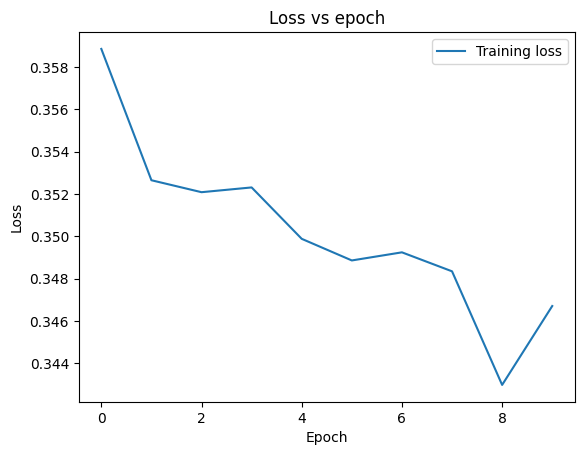

<function matplotlib.pyplot.legend(*args, **kwargs)>

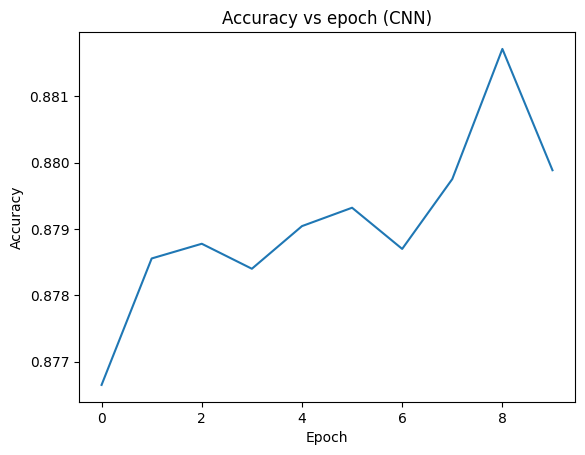

In [ ]:
# Plot the loss function graph
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epoch')
plt.legend()
plt.show()

# Plot the accuracy graph
plt.plot(train_accs, label='Training accuracy')
plt.title('Accuracy vs epoch (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend

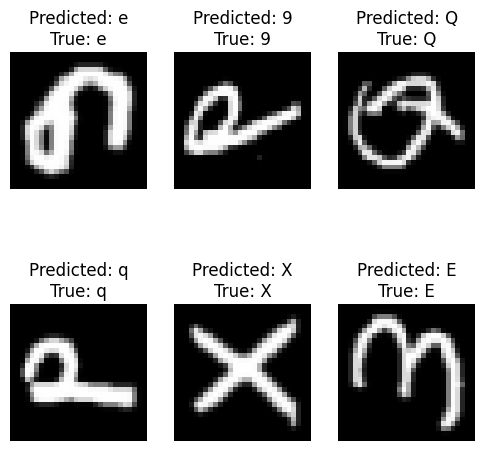

In [ ]:
# Checking the first 6 labels' prediction and true values 

figure=plt.figure(figsize=(6,6))
for i in range(1, 7):
    
    input, true_label = test_loader.dataset[i] 
    input = input.unsqueeze(0)
    predict_batch = model(input)
    a=predict_batch[0].tolist()
    pred_label= a.index(max(a))

    figure.add_subplot(2, 3, i)
    plt.title(f'Predicted: {emnist_dict[pred_label]}\nTrue: {emnist_dict[true_label]}')
    # plt.title(emnist_dict[pred_label])
    # plt.xlabel(emnist_dict[true_label])
    plt.axis("off")
    plt.imshow(input.squeeze(), cmap="gray")
plt.show()

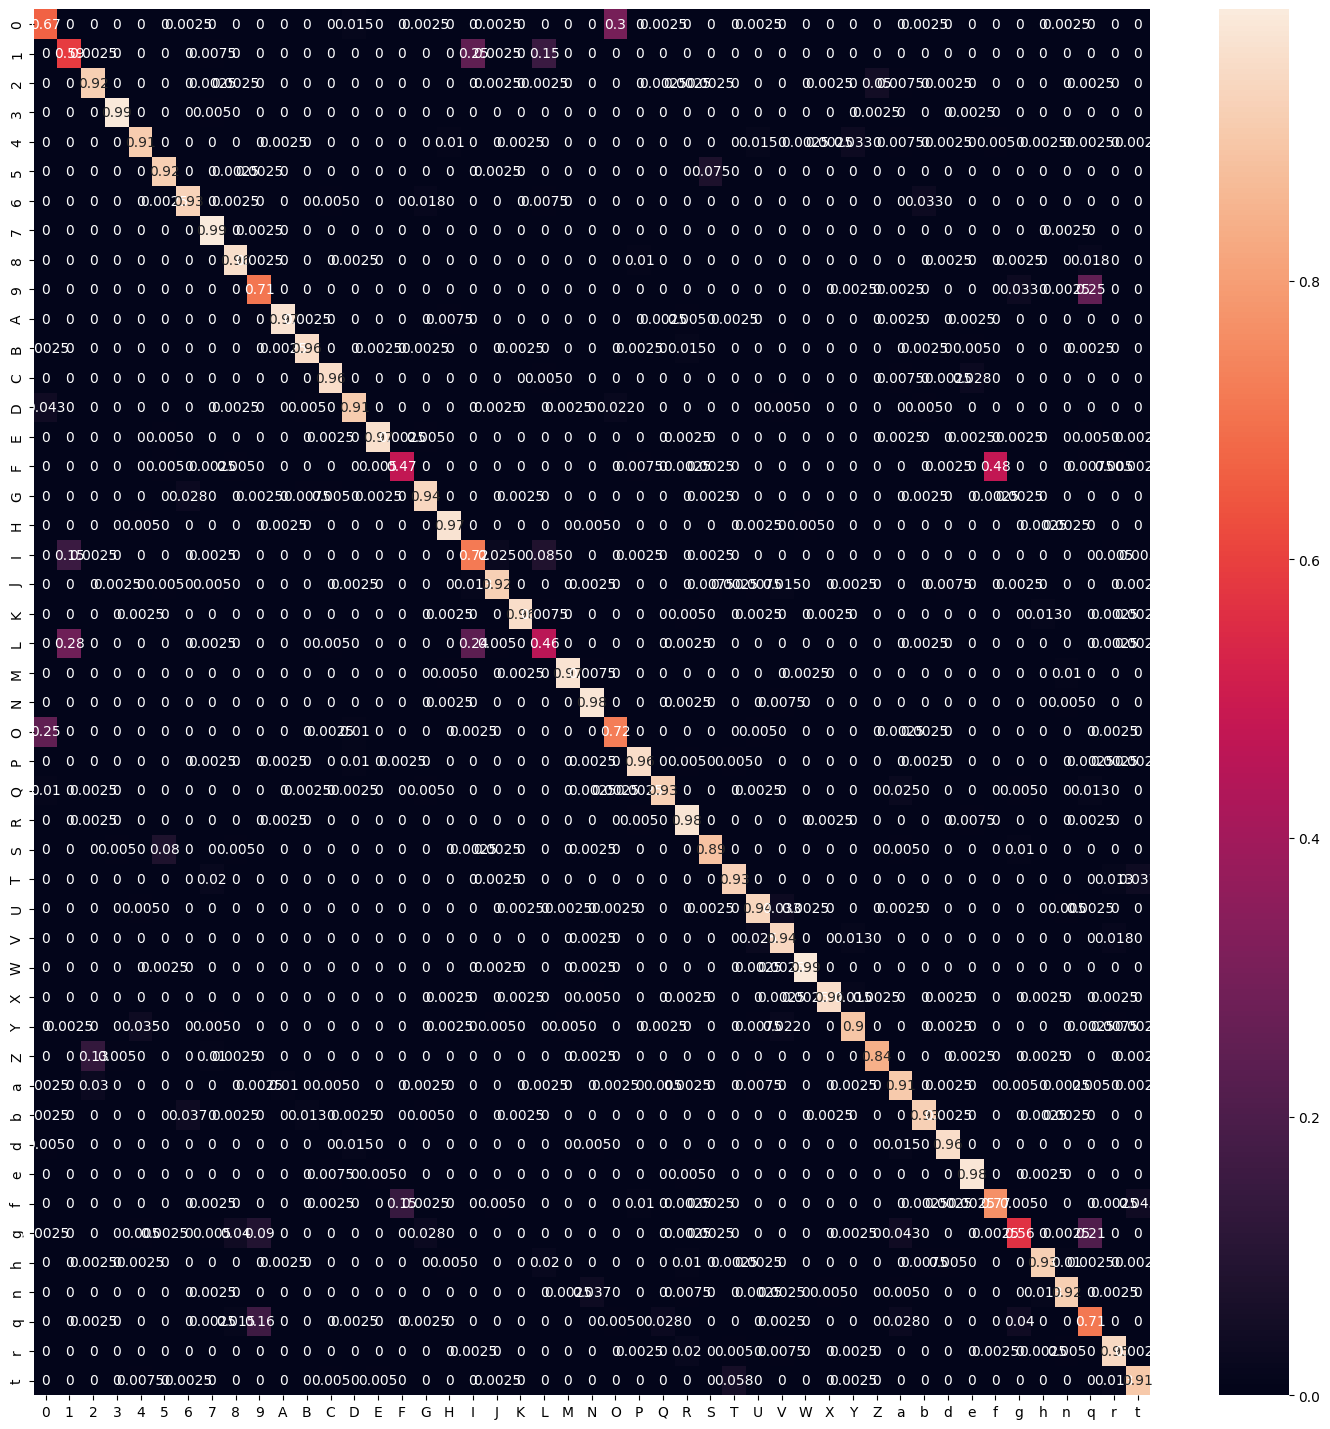

In [ ]:
y_pred = []
y_true = []

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn



for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = (emnist_dict.values())


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (18,18))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
# Precision, Recall and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision for best CNN model is {precision*100:.2f}")
print(f"Recall for best CNN model is {recall*100:.2f}")
print(f"F1 for best CNN model is {f1*100:.2f}")

Precision for best CNN model is 87.76
Recall for best CNN model is 87.76
F1 for best CNN model is 87.76


## Model Comparison Summary

##### Both MLP and CNN models have performed fairly well on the EMNIST dataset. The best models after doing the hyperparamter tuning have accuracies of **87.26%** and **87.76%** for MLP and CNN respectively. This suggests that given the right sets of hyperparameters, we can achieve similar results through MLP and CNN.
#### On the other hand, Precision, Recall and F1 score for both the models are in close range, suggesting that the performance is similar through different evaluation metrics.